# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Model Selection

[Discuss the type(s) of models you consider for this task, and justify the selection.]



## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


## Define Environment

In [ ]:
import os
base_dir = os.path.dirname(os.getcwd())
path_images = os.path.join(base_dir, "1_DatasetCharacteristics", "EruptionImages", "sorted images", "train_val")
path_images_synth_input_act_yes = os.path.join(base_dir, "1_DatasetCharacteristics", "EruptionImages", "sorted images","train_val", "activity yes")
path_images_synth_input_act_no = os.path.join(base_dir, "1_DatasetCharacteristics", "EruptionImages", "sorted images" ,"train_val", "activity no")
path_images_synth_output_act_yes = os.path.join(base_dir, "1_DatasetCharacteristics", "EruptionImages", "synth", "synth activity yes")
path_images_synth_output_act_no = os.path.join(base_dir, "1_DatasetCharacteristics", "EruptionImages", "synth", "synth activity no")
path_images_synth_output_input = os.path.join(base_dir, "1_DatasetCharacteristics", "EruptionImages", "synth")

print(base_dir, path_images)

## Import data

In [ ]:
# import original dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    path_images,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True,   # randomize
    color_mode='rgb',   # this strips alpha if present
    seed=42
)

# Get the class names
print("Class names:", dataset.class_names)

counts = {0: 0, 1: 0}

for images, labels in dataset:
    unique, counts_batch = np.unique(labels.numpy(), return_counts=True)
    for u, c in zip(unique, counts_batch):
        counts[u] += c

print(f"Label counts: {counts}")

In [ ]:
import tensorflow as tf
import os

# 1. Setup paths
input_dir = path_images
output_dir = path_images_synth

os.makedirs(output_dir, exist_ok=True)

# 2. Define augmentation function
def augment_image(image):
    # Randomly rotate by 0°, 90°, 180°, or 270°
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0, 255)
    return image

# 3. Process each image
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(input_dir, filename)
        img_raw = tf.io.read_file(img_path)
        img = tf.image.decode_image(img_raw, channels=3)
        img = tf.cast(img, tf.float32)

        for i in range(5):
            aug_img = augment_image(img)
            aug_img = tf.cast(aug_img, tf.uint8)

            new_filename = f"{os.path.splitext(filename)[0]}_aug{i}.jpg"
            output_path = os.path.join(output_dir, new_filename)

            encoded_img = tf.io.encode_jpeg(aug_img)
            tf.io.write_file(output_path, encoded_img)

print(f"Done. Augmented images saved to: {output_dir}")


In [ ]:
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_batches = int(total_batches * 0.8)
val_batches = total_batches - train_batches

train_ds_baseline = dataset.take(train_batches)
val_ds_baseline = dataset.skip(train_batches)

#### synthetic data: run once to create the dataset

In [27]:
# create synthetic data (run only onces)

# paths = [
#     (path_images_synth_input_act_yes, path_images_synth_output_act_yes),
#     (path_images_synth_input_act_no, path_images_synth_output_act_no)
# ]

# # make sure output dirs exist
# for _, output_dir in paths:
#     os.makedirs(output_dir, exist_ok=True)

# # augmentation
# def augment_image(image):
#     k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
#     image = tf.image.rot90(image, k)

#     image = tf.image.random_brightness(image, max_delta=0.3)
#     image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

#     noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=5.0)
#     image = image + noise

#     # simple blur
#     kernel = tf.constant([[1/9, 1/9, 1/9],
#                           [1/9, 1/9, 1/9],
#                           [1/9, 1/9, 1/9]], dtype=tf.float32)
#     kernel = kernel[:, :, tf.newaxis, tf.newaxis]
#     kernel = tf.repeat(kernel, repeats=3, axis=2)

#     image_exp = tf.expand_dims(image, axis=0)
#     blurred = tf.nn.depthwise_conv2d(image_exp, kernel, strides=[1,1,1,1], padding='SAME')
#     image = tf.squeeze(blurred, axis=0)

#     image = tf.clip_by_value(image, 0, 255)
#     return image

# # loop over all (input, output) pairs
# for input_dir, output_dir in paths:
#     for filename in os.listdir(input_dir):
#         if filename.lower().endswith('.jpg') or filename.lower().endswith('.png'):
#             img_path = os.path.join(input_dir, filename)
#             img_raw = tf.io.read_file(img_path)
#             img = tf.image.decode_image(img_raw, channels=3)
#             img = tf.cast(img, tf.float32)

#             for i in range(5):
#                 aug_img = augment_image(img)
#                 aug_img = tf.cast(aug_img, tf.uint8)

#                 new_filename = f"{os.path.splitext(filename)[0]}_aug{i}.jpg"
#                 output_path = os.path.join(output_dir, new_filename)

#                 encoded_img = tf.io.encode_jpeg(aug_img)
#                 tf.io.write_file(output_path, encoded_img)

# print("Done. All augmented images saved.")


In [ ]:
# import test images with for the model unknown vulcano

path_images_test = os.path.join(base_dir, "1_DatasetCharacteristics", "EruptionImages", "sorted images", "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

TEST_DIR = path_images_test

test_df = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

print("Test dataset loaded")
print(f"Class names: {test_df.class_names}")

counts = {0: 0, 1: 0}

for images, labels in test_df:
    unique, counts_batch = np.unique(labels.numpy(), return_counts=True)
    for u, c in zip(unique, counts_batch):
        counts[u] += c

print(f"Label counts: {counts}")

In [ ]:
# import created synthetic images
# only run if dataset was created with the algorithm above

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

dataset_synth = tf.keras.utils.image_dataset_from_directory(
    path_images_synth_output_input,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True,   # randomize
    color_mode='rgb',   # this strips alpha if present
    seed=42
)

# Get the class names
print("Class names:", dataset_synth.class_names)

counts = {0: 0, 1: 0}

for images, labels in dataset_synth:
    unique, counts_batch = np.unique(labels.numpy(), return_counts=True)
    for u, c in zip(unique, counts_batch):
        counts[u] += c

print(f"Label counts: {counts}")

Found 4150 files belonging to 2 classes.
Class names: ['synth activity no', 'synth activity yes']
Label counts: {0: np.int64(2075), 1: np.int64(2075)}


In [7]:
# merge both the original and the synth data together
combined_dataset = dataset.concatenate(dataset_synth)

# shuffle again for better mixing
combined_dataset = combined_dataset.shuffle(1000)

# prefetch for performance
combined_dataset = combined_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# check one batch
for images, labels in combined_dataset.take(1):
    print("Batch shape:", images.shape, "Labels:", labels.numpy())

Batch shape: (32, 224, 224, 3) Labels: [[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [8]:
counts = {0: 0, 1: 0}

for images, labels in combined_dataset:
    unique, counts_batch = np.unique(labels.numpy(), return_counts=True)
    for u, c in zip(unique, counts_batch):
        counts[u] += c

print(f"Label counts: {counts}")

Label counts: {0: np.int64(2490), 1: np.int64(2490)}


In [9]:
# create train and validation set 

total_batches = tf.data.experimental.cardinality(combined_dataset).numpy()
train_batches = int(total_batches * 0.8)
val_batches = total_batches - train_batches

train_ds = combined_dataset.take(train_batches)
val_ds = combined_dataset.skip(train_batches)

def count_labels(ds):
    counts = {0: 0, 1: 0}
    for _, labels in ds:
        unique, counts_batch = np.unique(labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts_batch):
            counts[int(u)] += c
    return counts

print("Train:", count_labels(train_ds))
print("Validation:", count_labels(val_ds))




Train: {0: np.int64(2004), 1: np.int64(1962)}
Validation: {0: np.int64(481), 1: np.int64(543)}


## Model

### Baseline model

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

baseline_model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()


c:\Users\Fynn\Desktop\Fynns Desktop\Opencampus\sat-imagery-ml\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 98568)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │       788,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,785 (3.01 MB)

 Trainable params: 788,785 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = baseline_model.fit(
    train_ds_baseline,             
    validation_data=val_ds_baseline,  
    epochs=10
)

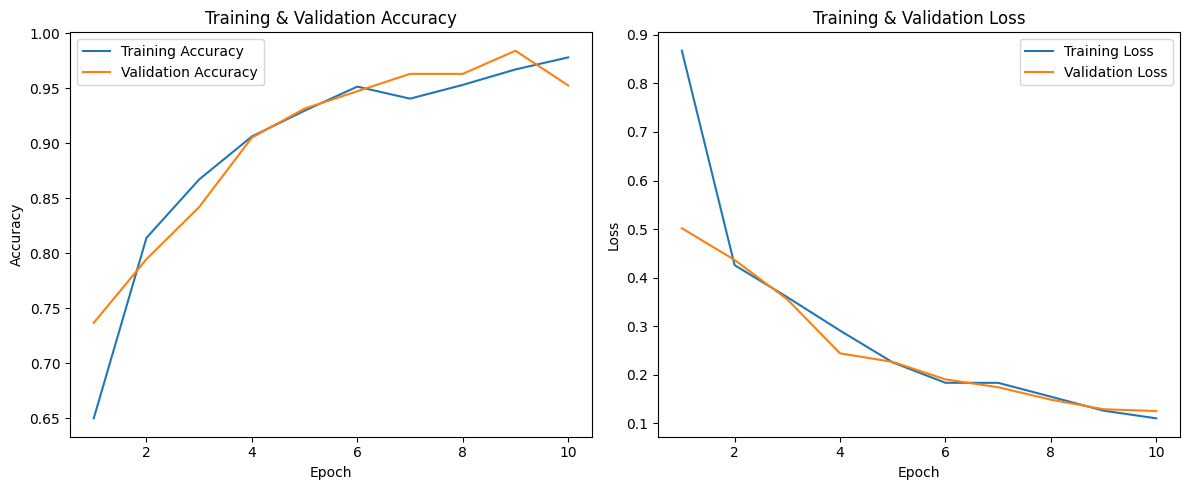

In [ ]:
import matplotlib.pyplot as plt

# extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Accuracy: 0.5677966101694916
Precision: 0.7857142857142857
Recall: 0.1864406779661017
F1 Score: 0.3013698630136986


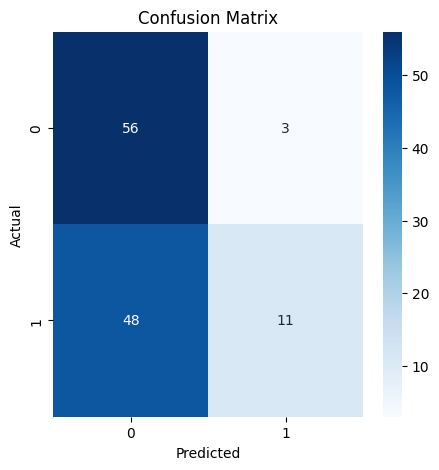

In [69]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_true = []
y_pred = []

for images, labels in test_df:
    preds = baseline_model.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_pred.extend(preds.flatten())

# Convert probabilities to binary
y_pred_labels = [1 if p >= 0.5 else 0 for p in y_pred]

# Compute metrics
acc = accuracy_score(y_true, y_pred_labels)
prec = precision_score(y_true, y_pred_labels)
rec = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Model for synth dataset

## Implementation Model 1


In [28]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Example model
model_synth = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  # binary classification
])

model_synth.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_synth.summary()

c:\Users\Fynn\Desktop\Fynns Desktop\Opencampus\sat-imagery-ml\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
# implement early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

history_synth = model_synth.fit(
    combined_dataset,
    validation_data=test_df,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

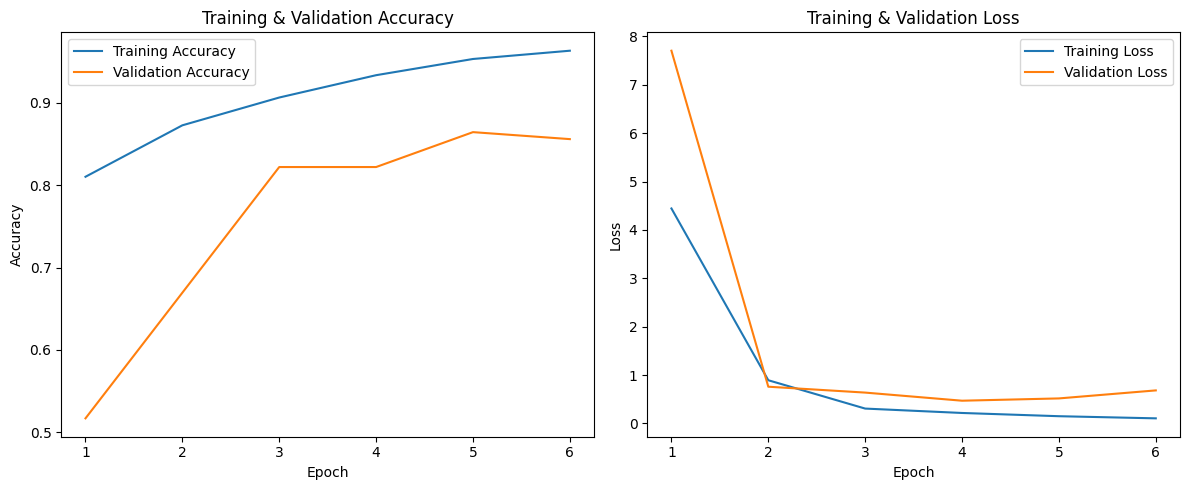

In [ ]:
import matplotlib.pyplot as plt

# extract metrics
acc = history_synth.history['accuracy']
val_acc = history_synth.history['val_accuracy']

loss = history_synth.history['loss']
val_loss = history_synth.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# plot
plt.figure(figsize=(12, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation Metrics

To evaluate the performance of the VolcaNet model, we use the following metrics:

Accuracy
Measures the overall proportion of correctly classified images. While useful as a general indicator, accuracy alone may be misleading due to potential class imbalance (e.g., fewer eruption images compared to non-eruptions).

Precision
Precision for the “active” class tells us how many of the predicted volcanic activity events were actually correct. This is especially important when false alarms (false positives) could waste resources or trigger unnecessary alerts.

Recall (Sensitivity)
Recall indicates how many of the actual volcanic activity events were correctly identified by the model. It is critical for early warning systems, where missing a real eruption (false negative) could have serious consequences.

F1-Score
The harmonic mean of precision and recall. It provides a balanced measure when dealing with uneven class distributions and is useful for assessing the model's ability to identify active volcanic phases accurately and reliably.

Confusion Matrix
A visual representation of true vs. predicted labels for both classes. This helps identify specific failure modes (e.g., frequent false positives for certain volcanoes) and supports targeted model improvement.

Why these metrics?
Volcanic activity classification is a high-risk binary classification problem where both false negatives (missed eruptions) and false positives (false alerts) have significant implications. Therefore, metrics like recall, precision, and F1-score are more informative than accuracy alone. 

In [31]:
model = keras.models.load_model('best_model.keras')
# get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_df:
    preds = model_synth.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_pred.extend(preds.flatten())

# convert predicted probabilities to binary class
y_pred_labels = [1 if p >= 0.5 else 0 for p in y_pred]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred_labels)
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8220338983050848
Precision: 1.0
Recall: 0.6440677966101694
F1 Score: 0.7835051546391752


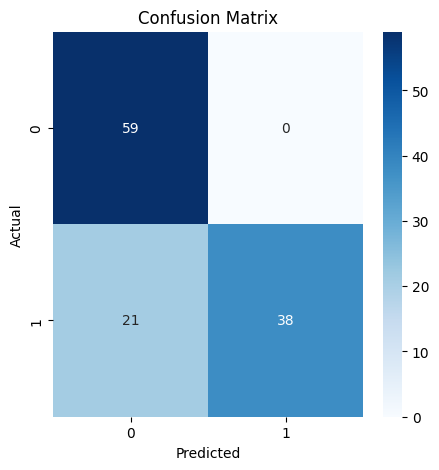

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning
In the MobileNet notebook, a grid search method was employed to systematically explore the effects of key hyperparameters on model performance. The parameters tuned included dropout rates (0.3 and 0.5), L2 regularization strength (0.001), learning rates (0.001 and 0.0005), and the number of training epochs (5 and 10). This approach was chosen to balance the model's ability to generalize while mitigating overfitting risks.

Training was conducted in two phases: initially, the pre-trained MobileNetV2 base was frozen to leverage existing learned features, followed by fine-tuning of the last 30 layers with a reduced learning rate. This staged training strategy helps preserve useful generic representations while allowing the model to adapt to the specific dataset.

Models were trained and evaluated for each combination of hyperparameters, with validation accuracies recorded to identify the best-performing configuration. 


**Implementation**
The final model utilizes the MobileNetV2 architecture pre-trained on ImageNet as the base. Data augmentation techniques—including random flipping, rotation, zoom, contrast, and translation—are applied to the input images to improve generalization.

Following the initial training phase with the base model frozen, the last 30 layers are unfrozen to enable fine-tuning with a lower learning rate. The model architecture consists of a global average pooling layer, followed by dropout and an L2-regularized dense layer with sigmoid activation for binary classification.

Hyperparameters selected for the final model correspond to those achieving the highest validation accuracy during the grid search. The model is compiled using the Adam optimizer and binary cross-entropy loss, trained on the training dataset, validated on the validation dataset, and saved for further evaluation or deployment.

For evaluation, the best model is loaded and tested on a separate test dataset. Predictions are generated and compared with true labels to compute performance metrics including accuracy, precision, recall, and F1 score. A confusion matrix is also visualized using a heatmap to provide insight into classification performance across classes. This comprehensive evaluation ensures the final model's effectiveness on unseen data. 




## Comparative Analysis

**Baseline CNN** – Underperforming Reference Point
The baseline model, a shallow one-layer CNN trained on the original dataset (830 images), performed poorly:

Accuracy: 56.8%

Precision: 78.6%

Recall: 18.6%

F1 Score: 0.30

Despite decent precision, the recall was very low — meaning the model missed most actual eruptions. This renders it unsuitable for real-world monitoring where failing to detect true positives is unacceptable. Its limited depth and insufficient training data contributed to severe underfitting.

**Custom Deep CNN** – Significant Improvement
After data augmentation (4150 images) and architectural enhancements, the deeper CNN achieved much better results:

Accuracy: 84.7%

Precision: 1.00

Recall: 69.5%

F1 Score: 0.82

This model managed to detect the majority of eruptions without producing any false positives. It represented a strong balance between robustness and simplicity, proving that careful architectural tuning and data expansion already bring significant gains over the baseline. However, some eruptions were still missed (false negatives), limiting its use in critical alerting scenarios.

**MobileNetV** (Transfer Learning) – Best Overall Performer
After implying the augmentation of the images in tensorflow directly in tensorflow and in combination with a pretrained MobileNetV2, we achieved state-of-the-art results:

Accuracy: 96.6%

Precision: 1.00

Recall: 93.2%

F1 Score: 0.965

This model generalized extremely well. It caught nearly all eruption events and made no false predictions. The combination of transfer learning, regularization (L2), and dropout contributed to both stability and generalization. It clearly demonstrates the power of pre-trained networks, especially when training data is limited.
